In [1]:
import numpy as np
import pandas as pd
import glob
import os
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import matplotlib.pylab as plt
import glob
from scipy.ndimage.interpolation import rotate
# import scipy
import sugartensor as tf
import sys
sys.path.append('../')
import UtilsLJ
from tqdm import tqdm
import sys
#sys.path.append('./PointSetGeneration/depthestimate')

os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="0"

#About Data

batSize=16
maxStep=600000 # fixed with learningRate and learningRateDecay
learningRate=1e-3
learningRateDecay=0.995
lrType=1 #learning rate type
lr2Period=5
adam_beta1=0.9 # check adam optimization
adam_beta2=0.99
conWeightVar=['NNReg','global_step'] # variables to be loaded
saveStep=100 # frequency to save weight
maxKeepWeights=2000 # how many records to save (for disk)
stepsContinue=-1  # from which steps continu.
#For Debug and results printing
keepProb=0.99999
# Totally dosen't work if put dropout after max-pool layer. 
printStep=5000
ss=2048
dat="Fish_Train_Deform=0.4"
FBN=0
NRT=1
dirSave="./TFweights/Simple{}_NR_{}_FBN_{}_Ss_{}_Bs_{}_lrT_{}_LR_{}_LRdecay_{}_Dkp_{}".format(
    dat, NRT, FBN, ss, batSize, lrType, learningRate, learningRateDecay,keepProb)

#conWeightPath="./TFweights/Simple2Dto3DMGPU_NR_1_FBN_0_Ss_1024_Bs_32_lrT_1_LR_0.001_LRdecay_0.999_Dkp_0.99999"
#conWeightPath="./TFweights/SimpleFishCorrProgress_NR_1_FBN_0_Ss_2048_Bs_16_lrT_1_LR_0.001_LRdecay_0.995_Dkp_0.99999"

#conWeightPath="./TFweights/SimpleFishEdge_NR_1_FBN_0_Ss_2048_Bs_16_lrT_1_LR_0.001_LRdecay_0.995_Dkp_0.99999"

conWeightPath=""

RSW=8
RSD=8

In [2]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)

In [3]:
def VisBat(yt,y_hat):
    import matplotlib.pylab as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(1, figsize=(5, 30))
    for j in range(10):
            d=np.asarray((yt[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(3, 3))
            ax = fig.add_subplot(32, 2, j*2+1)
            ax.scatter(d[:, 0],d[:, 1],s=20)
            ax.axis('off')

            d=np.asarray((y_hat[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(3, 3))
            ax = fig.add_subplot(32, 2, j*2+2)
            
            #d=pca.fit_transform(d)
            
            ax.scatter(d[:, 0],d[:, 1],s=20)
            ax.axis('off')

    plt.show() 

In [4]:
x=UtilsLJ.read_from_tfrecords(
    '../data/Fish_Train_Def=0.4.tfrecords',['x'],batSize,
                                  [[91,2]])


xt=UtilsLJ.read_from_tfrecords(
    '../data/Fish_Test_Def=0.4.tfrecords',['x'],batSize,
                                  [[91,2]])


# x_img=tf.image.resize_images(tf.tile(tf.expand_dims(x_img,dim=-1),[1,1,1,3]),[64,64])
# x_img_t=tf.image.resize_images(tf.tile(tf.expand_dims(x_img_t,dim=-1),[1,1,1,3]),[64,64])

# xTest, x_imgTest, yTest=UtilsLJ.read_from_tfrecords('/media/MMVCNYLOCAL_2/MMVC_NY/Lingjing_Wang/Data/ChairWithSingleImgTest.tfrecords'.format(name),['d_p_raw','d_raw'],32,
#                                              [[137,137,3],[32,32,32]],shuffle=False)

In [5]:
xx=tf.sg_print(x)

[[[-1.03864193 -0.13395739]
  [-1.00615239 -0.08710495]
  [-0.96051848 -0.07542333]
  ..., 
  [-1.21488667 -0.24270037]
  [-0.02137673 -0.41080105]
  [ 0.1647557  -0.4309755 ]]

 [[-0.77754331 -0.08079465]
  [-0.73271912 -0.0350073 ]
  [-0.71293199 -0.05804294]
  ..., 
  [-0.97099596 -0.10199231]
  [-0.2901974  -1.01836824]
  [-0.1184891  -1.02982342]]

 [[-1.18094134  0.19891962]
  [-1.17022693  0.25627512]
  [-1.12972009  0.25692517]
  ..., 
  [-1.30594552  0.08478025]
  [ 0.12341306 -0.59397292]
  [ 0.26773754 -0.61655748]]

 ..., 
 [[-0.99274385 -0.00923704]
  [-0.97690201  0.06457958]
  [-0.93974018  0.0673942 ]
  ..., 
  [-1.13438272 -0.1920779 ]
  [ 0.11960898 -0.53500974]
  [ 0.23088419 -0.56481385]]

 [[-0.90557599 -0.22496009]
  [-0.89480352 -0.18103772]
  [-0.86262548 -0.19304365]
  ..., 
  [-1.0224123  -0.28826541]
  [ 0.18722111 -0.99974954]
  [ 0.31440043 -0.99093711]]

 [[-0.99979138 -0.10406655]
  [-0.9869675  -0.0673513 ]
  [-0.96171999 -0.07466823]
  ..., 
  [-1.10036

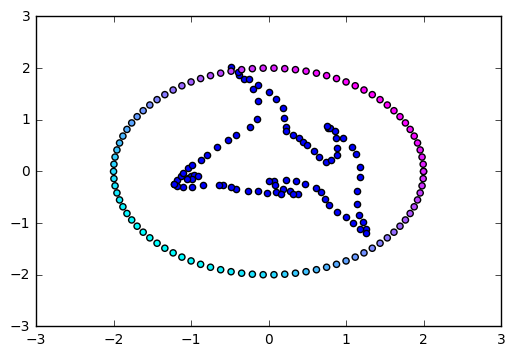

In [6]:
r=2
record=np.asarray([(r*np.cos(i), r*np.sin(i)) for i in np.linspace(0,2*np.pi,91)])

# x1,x2,x3=tf.sg_print([x,x_img,y])

k=0
plt.scatter(xx[k][:,0],xx[k][:,1])
plt.scatter(record[:,0],record[:,1],c=record.sum(axis=-1), cmap="cool")
plt.show()
# fig= plt.figure(1, figsize=(5, 5))
# ax = fig.add_subplot(1,1,1, projection='3d')
# ax.scatter(x3[k][:, 0],x3[k][:, 1],x3[k][:, 2])
# plt.show()
# plt.imshow(x2[k])
# plt.show()

In [7]:
record.shape

(91, 2)

In [8]:
def edge_loss(pred,edges):
    # edge in graph
    print(pred.shape, edges.shape)
    edges=tf.cast(edges,dtype=tf.int32)
    nod1 = tf.gather(pred,edges[:,0])
    nod2 = tf.gather(pred, edges[:,1])
    edge = tf.subtract(nod1, nod2)

    # edge length loss
    edge_length = tf.reduce_sum(tf.square(edge), 1)
    edge_loss = tf.reduce_mean(edge_length)
    return edge_loss

In [9]:
def NNReg(x, x1):
    with tf.sg_context(name='NNReg', stride=1, size=1,act='leaky_relu', bn=True, reuse=tf.AUTO_REUSE):
        
        
        x1=(tf.expand_dims(x1,2)).sg_conv(dim=64,name='l1')
        print(x1)
#         x2=x1.sg_conv(dim=64,name="l2")
        x3=x1.sg_conv(dim=64,name="l3")
        x4=x3.sg_conv(dim=128,name="l4")
        x5=x4.sg_conv(dim=512,name="l5")
        x5=tf.nn.max_pool(x5, ksize=[1, x1.shape[1], 1, 1], padding="VALID", strides=[1,1,1,1])
  
        print(x5)
        ffc1=tf.tile(x5,[1,x.shape[1],1,1])

        x=tf.expand_dims(x,2)
#         x=(xo).sg_conv(dim=16,name='ll1', size=1, stride=1)
#         x=x.sg_conv(dim=64,name="ll2",size=1, stride=1)

        xx=tf.concat([x, ffc1], axis=-1)

#         xx=xx.sg_conv(dim=256,name='ll3', size=1, stride=1)
#         xx=xx.sg_conv(dim=64,name="ll4",size=1, stride=1)
#         xx=xx.sg_conv(dim=3,name="ll5",size=1, stride=1)

#         xx=tf.concat([xx, ffc1], axis=-1)

        xx=xx.sg_conv(dim=256,name='ll6', size=1, stride=1)
        xx=xx.sg_conv(dim=64,name="ll7",size=1, stride=1)
        xx=xx.sg_conv(dim=2,name="ll8",size=1, stride=1, act="linear", bn=False)  
        
        xx=x+xx
        
        xx=tf.squeeze(xx,axis=2)
        
        
    return xx

In [10]:
def chamfer_loss(A,B):    
    r=tf.reduce_sum(A*A,2)
    r=tf.reshape(r,[int(r.shape[0]),int(r.shape[1]),1])
    r2=tf.reduce_sum(B*B,2)
    r2=tf.reshape(r2,[int(r.shape[0]),int(r.shape[1]),1])
    t=(r-2*tf.matmul(A, tf.transpose(B,perm=[0, 2, 1])) + tf.transpose(r2,perm=[0, 2, 1]))
    return tf.reduce_mean(tf.reduce_min(t, axis=1)+tf.reduce_min(t,axis=2))

# def gaussian_mix_loss(x_hat, y, var=0.1):
#     bs=x_hat.shape[0]
#     n1=y.shape[1]
#     n2=x_hat.shape[1]

#     tmp1=tf.tile(tf.expand_dims(x_hat,1),[1,n1,1,1])
#     tmp2=tf.tile(tf.expand_dims(y,2),[1,1,n2,1])
#     #tmp3=(tf.expand_dims(tmp1-tmp2, dim=3))
#     tmp3=(tmp1-tmp2)**2

# #     tmp4=tf.transpose(tmp3, [0,1,2,4,3])

# #     sigma=tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.eye(3)*(1/var),0),0),0)
# #     sigma_inverse=tf.tile(sigma,[bs,n1,n2,1,1])

# #     tmp=tf.matmul(tf.matmul(tmp3,sigma_inverse), tmp4)
#     tmp=tf.reduce_sum(tmp3, axis=-1)/var
#     tmp=tf.exp(-0.5*tmp)
#     tmp=tmp/(2*np.pi*var)
#     tmp=tf.squeeze(tmp)
#     tmp=tf.reduce_mean(tmp, axis=-1)
#     loss=tf.reduce_mean(-tf.log(tmp))
#     return loss

In [11]:
def VisBatFold(x, yt,y_hat):
    import matplotlib.pylab as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(1, figsize=(30, 10))
    for j in range(1):
            d1=np.asarray((x[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(10, 10))
            ax = fig.add_subplot(1, 3, j*3+1)
            ax.scatter(d1[:, 0], d1[:, 1], c=d1[:, 0]+d1[:, 1], s=35, cmap="plasma")
#             ax.set_xlim(0,1)
#             ax.set_ylim(0,1)
#             ax.set_zlim(0,1)
            
            ax.axis('off')

            d=np.asarray((yt[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(10, 10))
            ax = fig.add_subplot(1, 3, j*3+2)
            ax.scatter(d[:, 0],d[:, 1],s=35, cmap="plasma")
#             ax.set_xlim(0,1)
#             ax.set_ylim(0,1)
#             ax.set_zlim(0,1)
            
            
            ax.axis('off')

            d=np.asarray((y_hat[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(10, 10))
            ax = fig.add_subplot(1, 3, j*3+3)
#             ax.set_xlim(0,1)
#             ax.set_ylim(0,1)
#             ax.set_zlim(0,1)
            
            #d=pca.fit_transform(d)
            
            ax.scatter(d[:, 0],d[:, 1],c=d1[:, 0]+d1[:, 1], s=35, cmap="plasma")
            ax.axis('off')
            

    plt.show() 

In [12]:
def VisBat(x, yt,y_hat):
    import matplotlib.pylab as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(1, figsize=(15, 30))
    for j in range(6):
            d1=np.asarray((x[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(10, 10))
            ax = fig.add_subplot(6, 3, j*3+1)
            ax.scatter(d1[:, 0], d1[:, 1], c=range(len(d1)), s=20, cmap="plasma")
            
            for iii in range(0, len(d1),3):
                ax.text(d1[iii,0], d1[iii,1], str(iii))
            
            ax.axis('off')
        
            d=np.asarray((yt[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(5, 5))
            ax = fig.add_subplot(6, 3, j*3+2)
            ax.scatter(d[:, 0],d[:, 1],s=20)
            for iii in range(0, len(d),3):
                ax.text(d[iii,0], d[iii,1], str(iii))
            
            ax.axis('off')

            d=np.asarray((y_hat[j])).reshape(-1,2)
            fig = plt.figure(1, figsize=(5, 5))
            ax = fig.add_subplot(6, 3, j*3+3)                        
            ax.scatter(d[:, 0],d[:, 1],c=range(len(d1)), s=20, cmap="plasma")
            for iii in range(0, len(d1),3):
                ax.text(d[iii,0], d[iii,1], str(iii))
            ax.axis('off')

    plt.show() 

In [ ]:
def train():
    tf.reset_default_graph()
    tf.set_random_seed(888)
    print("*****************************************")
    print("Training started with random seed: {}".format(RSW))
    print("Batch started with random seed: {}".format(RSD))
    
    x=UtilsLJ.read_from_tfrecords(
        '../data/Fish_Train_Def=0.4.tfrecords',['x'],batSize,
                                      [[91,2]])


    xt=UtilsLJ.read_from_tfrecords(
        '../data/Fish_Test_Def=0.4.tfrecords',['x'],batSize,
                                      [[91,2]])

    tf_circle = tf.constant(record, dtype=tf.float32)
    xx=tf.tile(tf.expand_dims(tf_circle,dim=0), [batSize,1,1])
    
    
    global_step = tf.Variable(1, trainable=False,name='global_step')

    # get the output from network
    
    y_hat=NNReg(xx,x)
    
    y_hat_Test=NNReg(xx,xt)

    cl=chamfer_loss(y_hat, x)*3000
    #el=edge_loss(y_hat,edges_mesh)*300

    Loss=cl
    
    
    LossT=chamfer_loss(y_hat_Test, xt)
    

    #Learning Rate****************************************************************************
    
    lr = tf.train.exponential_decay(learningRate, global_step,
                                                  100, learningRateDecay, staircase=False) 
    lr=tf.clip_by_value(lr, 1e-5,1)
    
    # Optimization Algo************************************************************************
    train_step = tf.train.AdamOptimizer(learning_rate=lr,
                                                    beta1=adam_beta1,
                                                    beta2=adam_beta2
                                                   ).minimize(Loss,global_step=global_step)
    
    saver = tf.train.Saver(max_to_keep=int(maxKeepWeights))
   
    init_op = tf.group(tf.global_variables_initializer(),
                               tf.local_variables_initializer())
    
    # Continue Training************************************************************************
    if len(conWeightPath)>0:
        print("Continue Training...")
        tmp_var_list={}
        if len(conWeightVar)==0:
            print("For all variables")
            globals()['conWeightVar']={''}
        else:
            print("Training variables: {}".format(conWeightVar))
            
        for j in conWeightVar: 
            for i in tf.global_variables():
                if i.name.startswith(j):
                    tmp_var_list[i.name[:-2]] = i
                    
        saver1=tf.train.Saver(tmp_var_list) 
    # For Testing Dosent matther****************************************************************   
    
    
    # Training**********************************************************************************    
    with tf.Session() as sess:
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        # Read Weight******************************
        if len(conWeightPath)>0:
            print(conWeightPath)
            if stepsContinue==-1:            
                STEPS=sorted([int(i.split("/")[-1].split(".")[1].split("-")[-1]) for i in glob.glob(conWeightPath+"/*meta")])
                globals()['stepsContinue']=STEPS[-1]
                
            wtt=glob.glob(conWeightPath+"/*{}*meta".format(stepsContinue))[0][:-5]
            print("Reading Weight:{}".format(wtt))
            saver1.restore(sess,wtt)
            print('Weight is successfully updated from: {}'.format(wtt))  
        #*******************************************    
        
        stepst = sess.run(global_step)
        
        
        #TestRes=[]
        #maxStep=1600/batSize
        
        for t in tqdm(range(stepst,int(maxStep)+1)):
            
            _, llr,Ltr, LT= sess.run([train_step, lr,Loss, LossT]) 
            
#             print(Ltr)
#             TestRes.append(LT)
#             print(np.mean(TestRes))
            
            if t==stepst:
                Ls=1
            else:
                Ls=0.99*Ls+0.01*Ltr
                
            #RL=0.999*RL+0.001*regL
            
            if (t in np.array([0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 5, 10, 20,30])*1000) | (t % printStep==0):
                #f0,f1, f2, ccl,eel=sess.run([xx, x, y_hat,cl,el])
                f0,f1, f2=sess.run([xx, x, y_hat])
                VisBat(f0,f1,f2)
#                 VisBatFold(f0,f1,f2)
                
                print(Ls)
#                 print("Edge Loss:", eel)
#                 print("Chamfer Loss", ccl)
                
#             if t% printStep==0:
#                 f0,f1, f2=sess.run([xx, y,y_hat])
#                 VisBat(f1,f2)
#                 VisBatFold(f0,f1,f2)
            if t% 1000==0:
                if not os.path.exists(dirSave):
                    os.makedirs(dirSave)
                    
                with open(dirSave + '/result.txt', 'a') as f:
                    f.write(str(llr)+"*"+str(Ls)+"\n")
            
            if (t in np.array([0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 5, 10, 20,30])*1000) | (t % saveStep==0):
                if not os.path.exists(dirSave):
                    os.makedirs(dirSave)
                saver.save(sess, dirSave + '/model.ckpt', global_step=t)
                
        coord.request_stop()
        coord.join(threads)        

*****************************************
Training started with random seed: 8
Batch started with random seed: 8
Tensor("NNReg/l1/out:0", shape=(16, 91, 1, 64), dtype=float32)
Tensor("NNReg/MaxPool:0", shape=(16, 1, 1, 512), dtype=float32)
Tensor("NNReg_1/l1/out:0", shape=(16, 91, 1, 64), dtype=float32)
Tensor("NNReg_1/MaxPool:0", shape=(16, 1, 1, 512), dtype=float32)


  0%|          | 98/600000 [00:03<5:34:59, 29.85it/s]

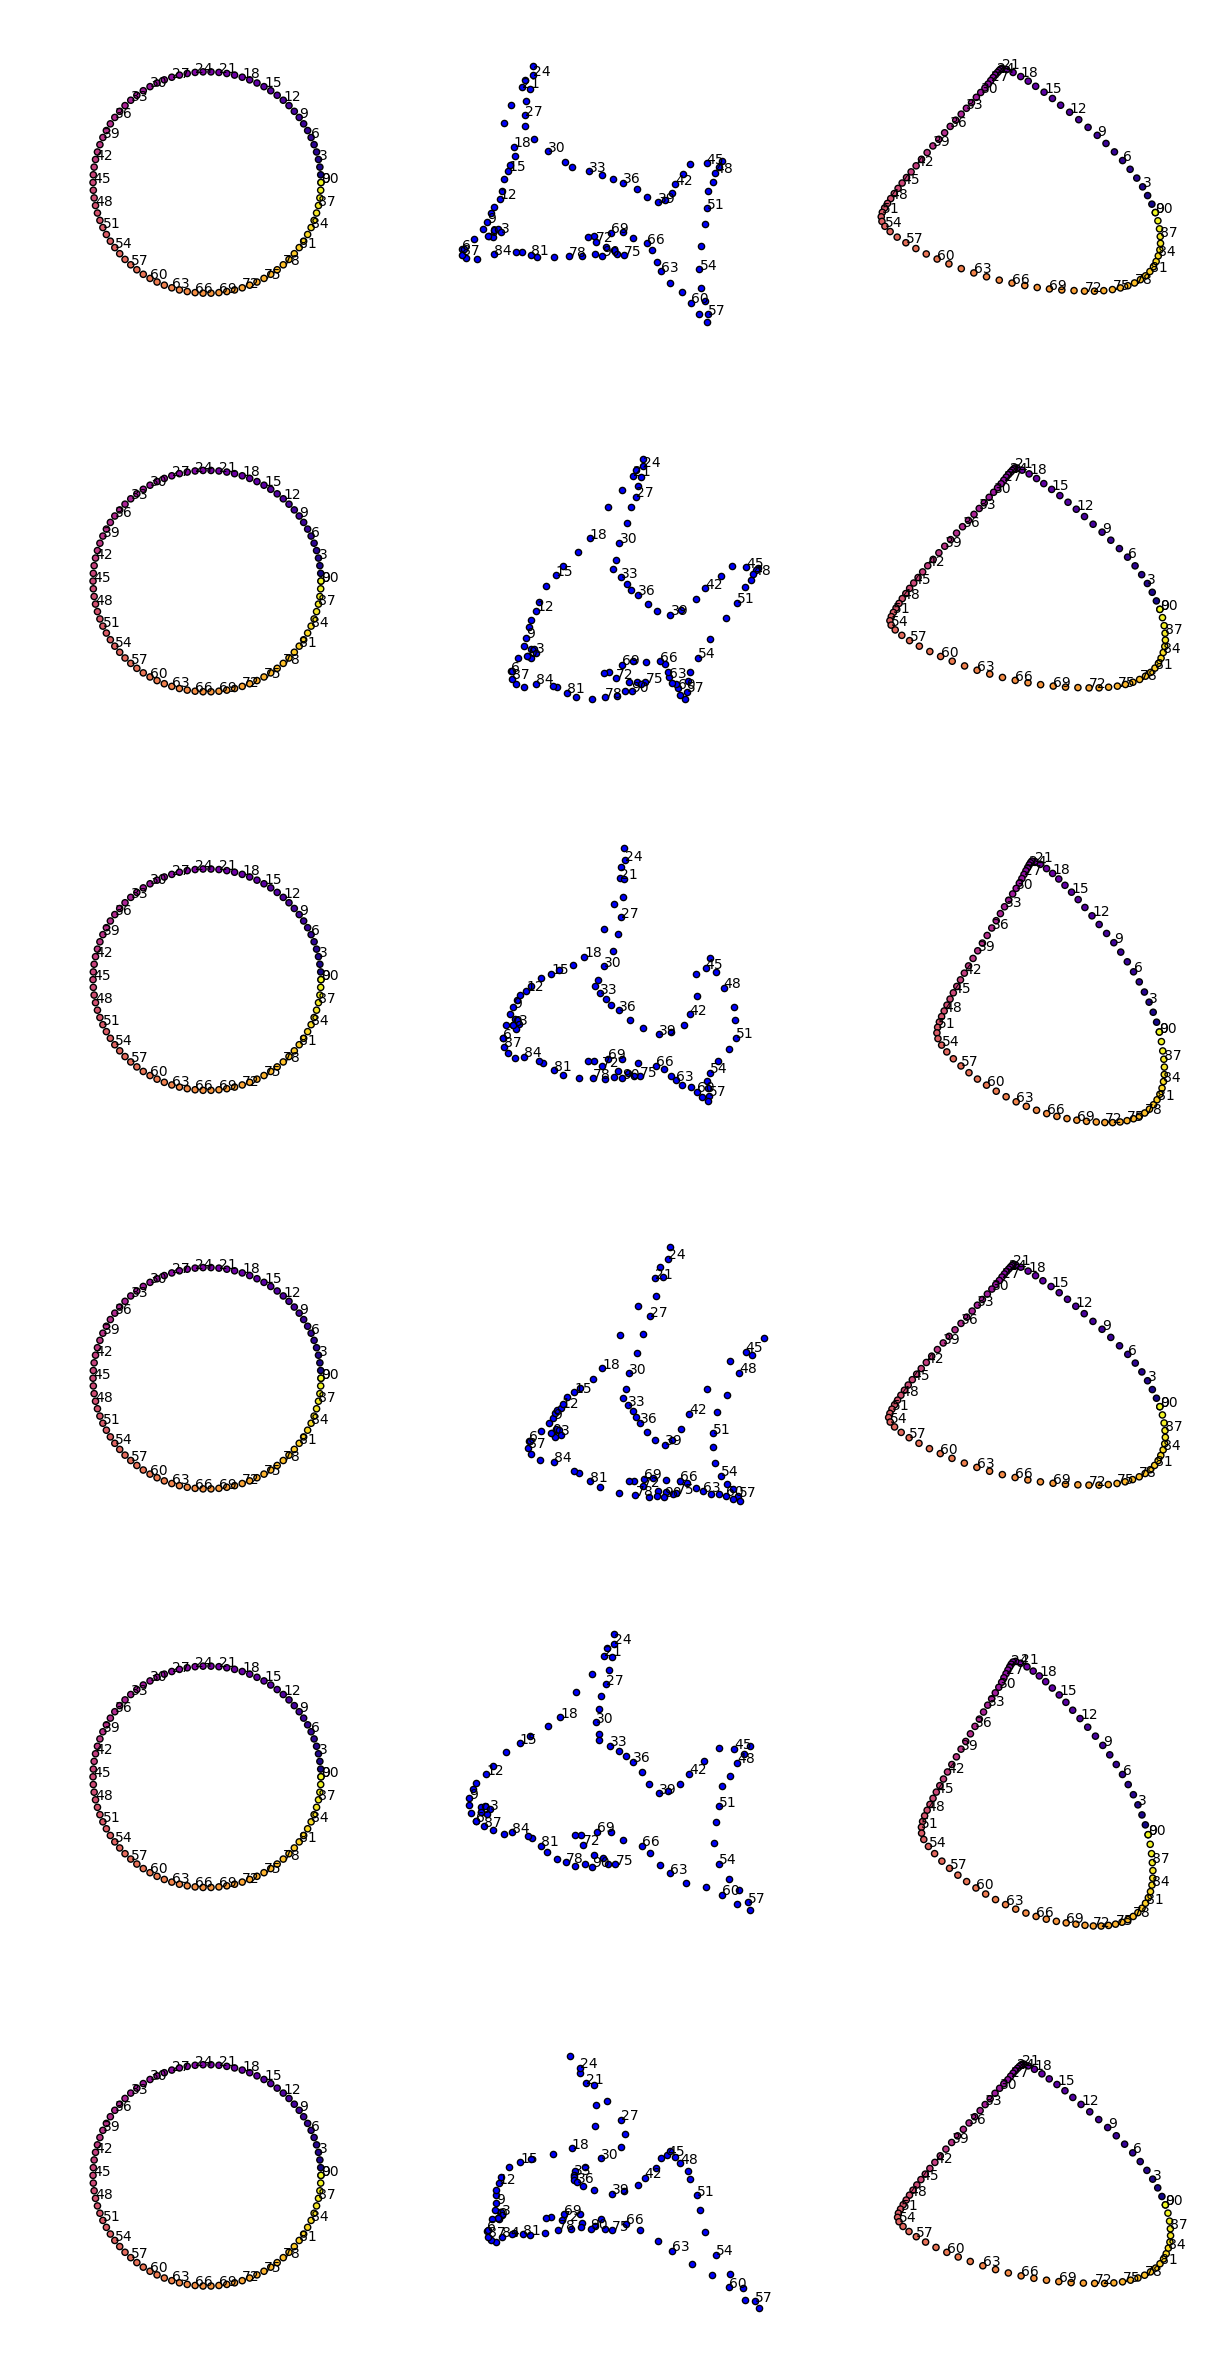

541.307451527


  0%|          | 193/600000 [00:10<9:28:20, 17.59it/s]

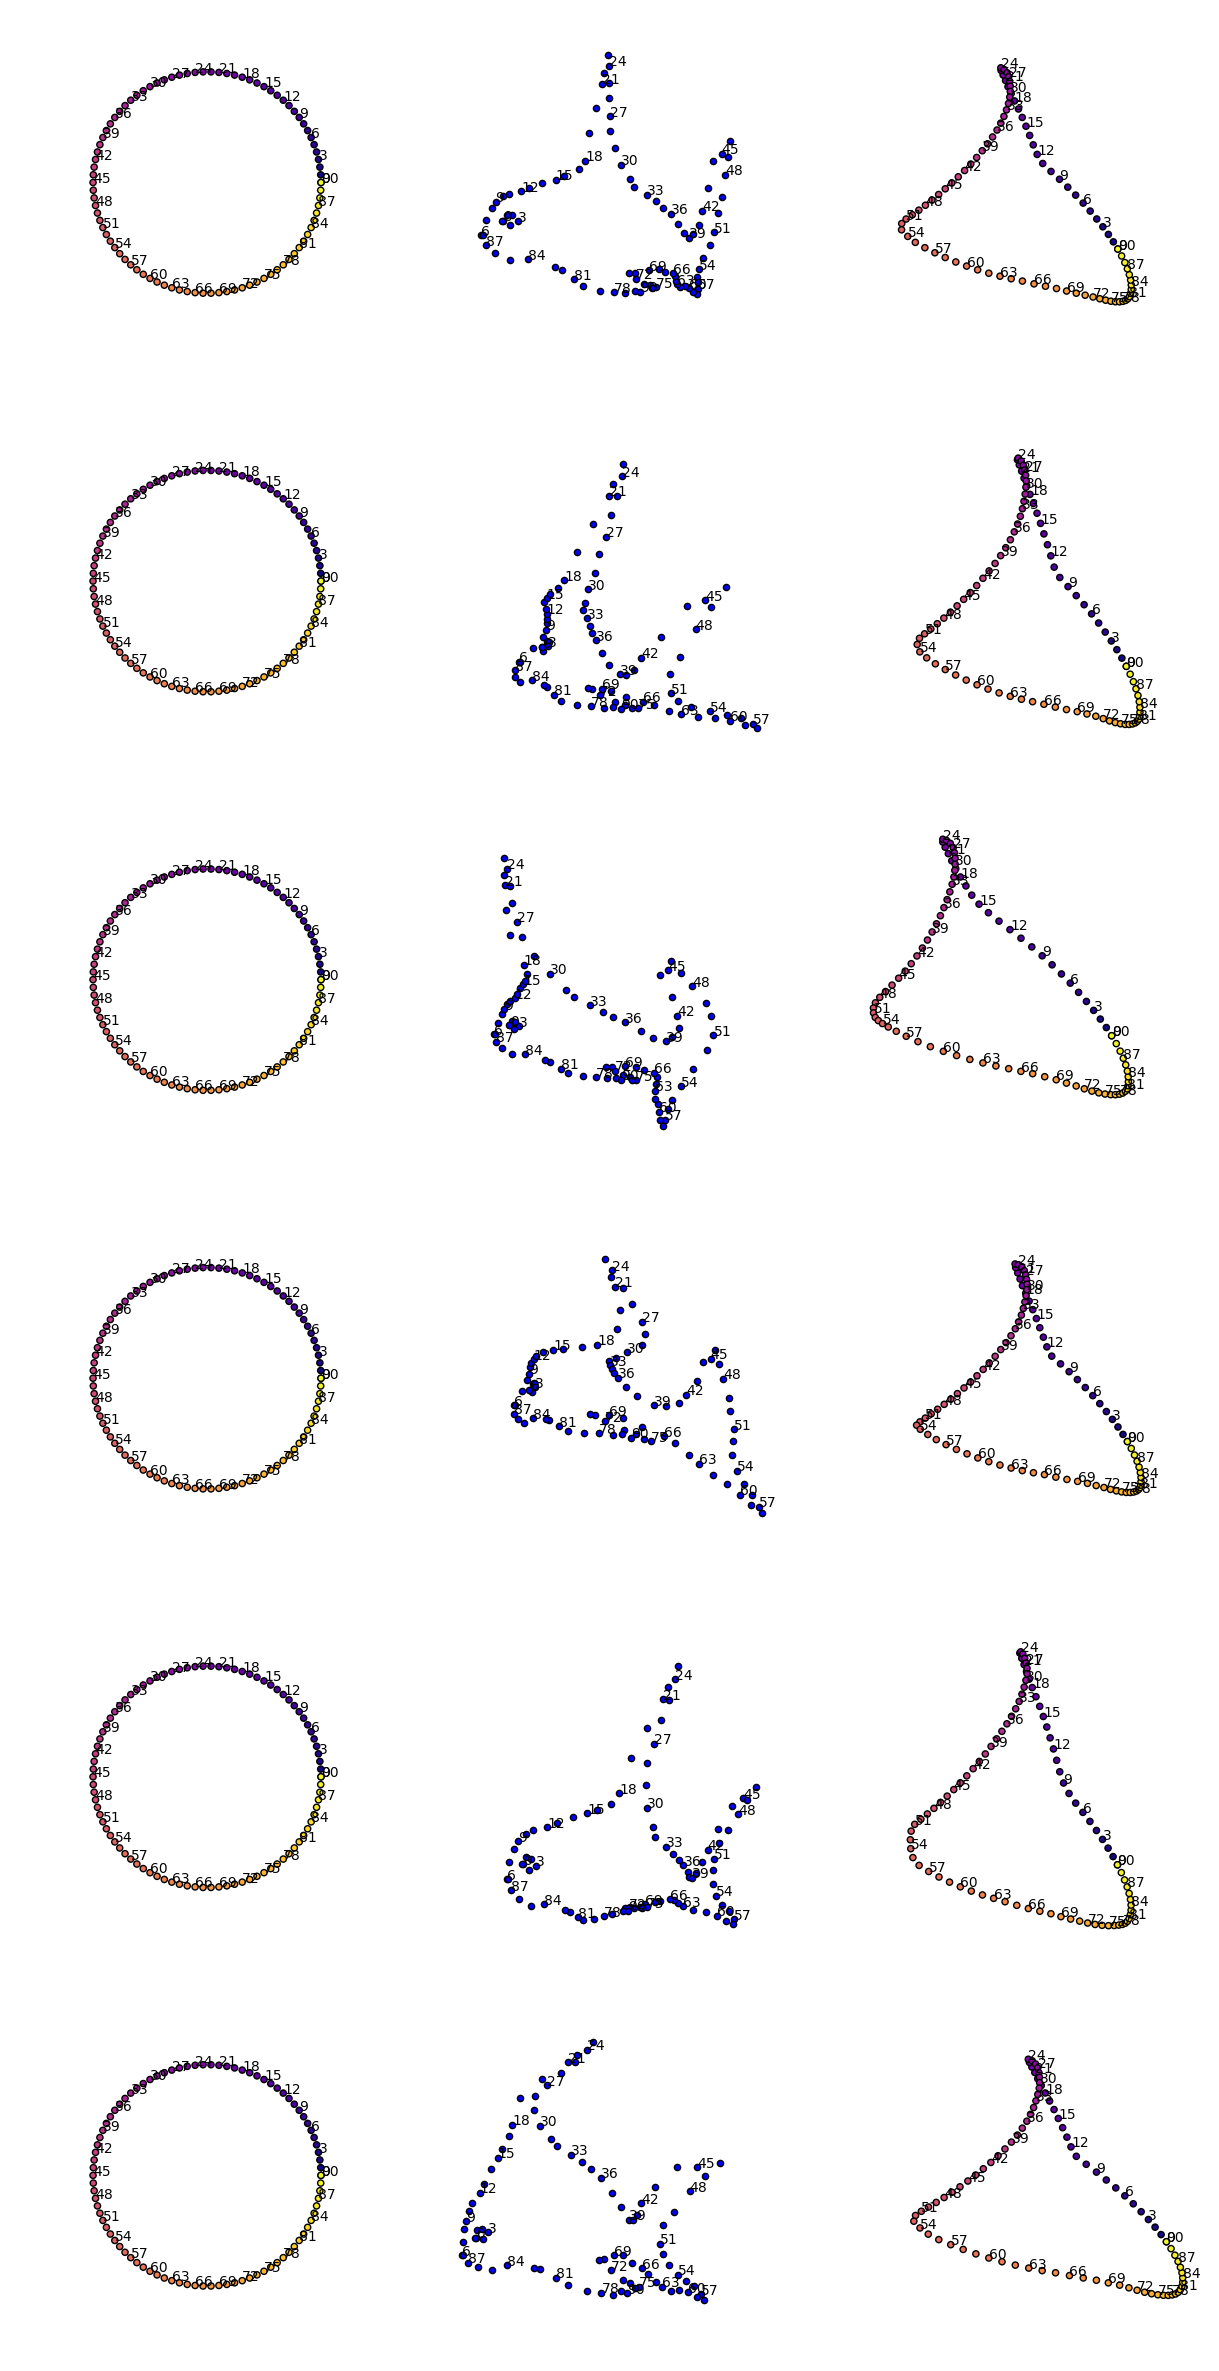

387.972514153


  0%|          | 298/600000 [00:18<10:13:59, 16.28it/s]

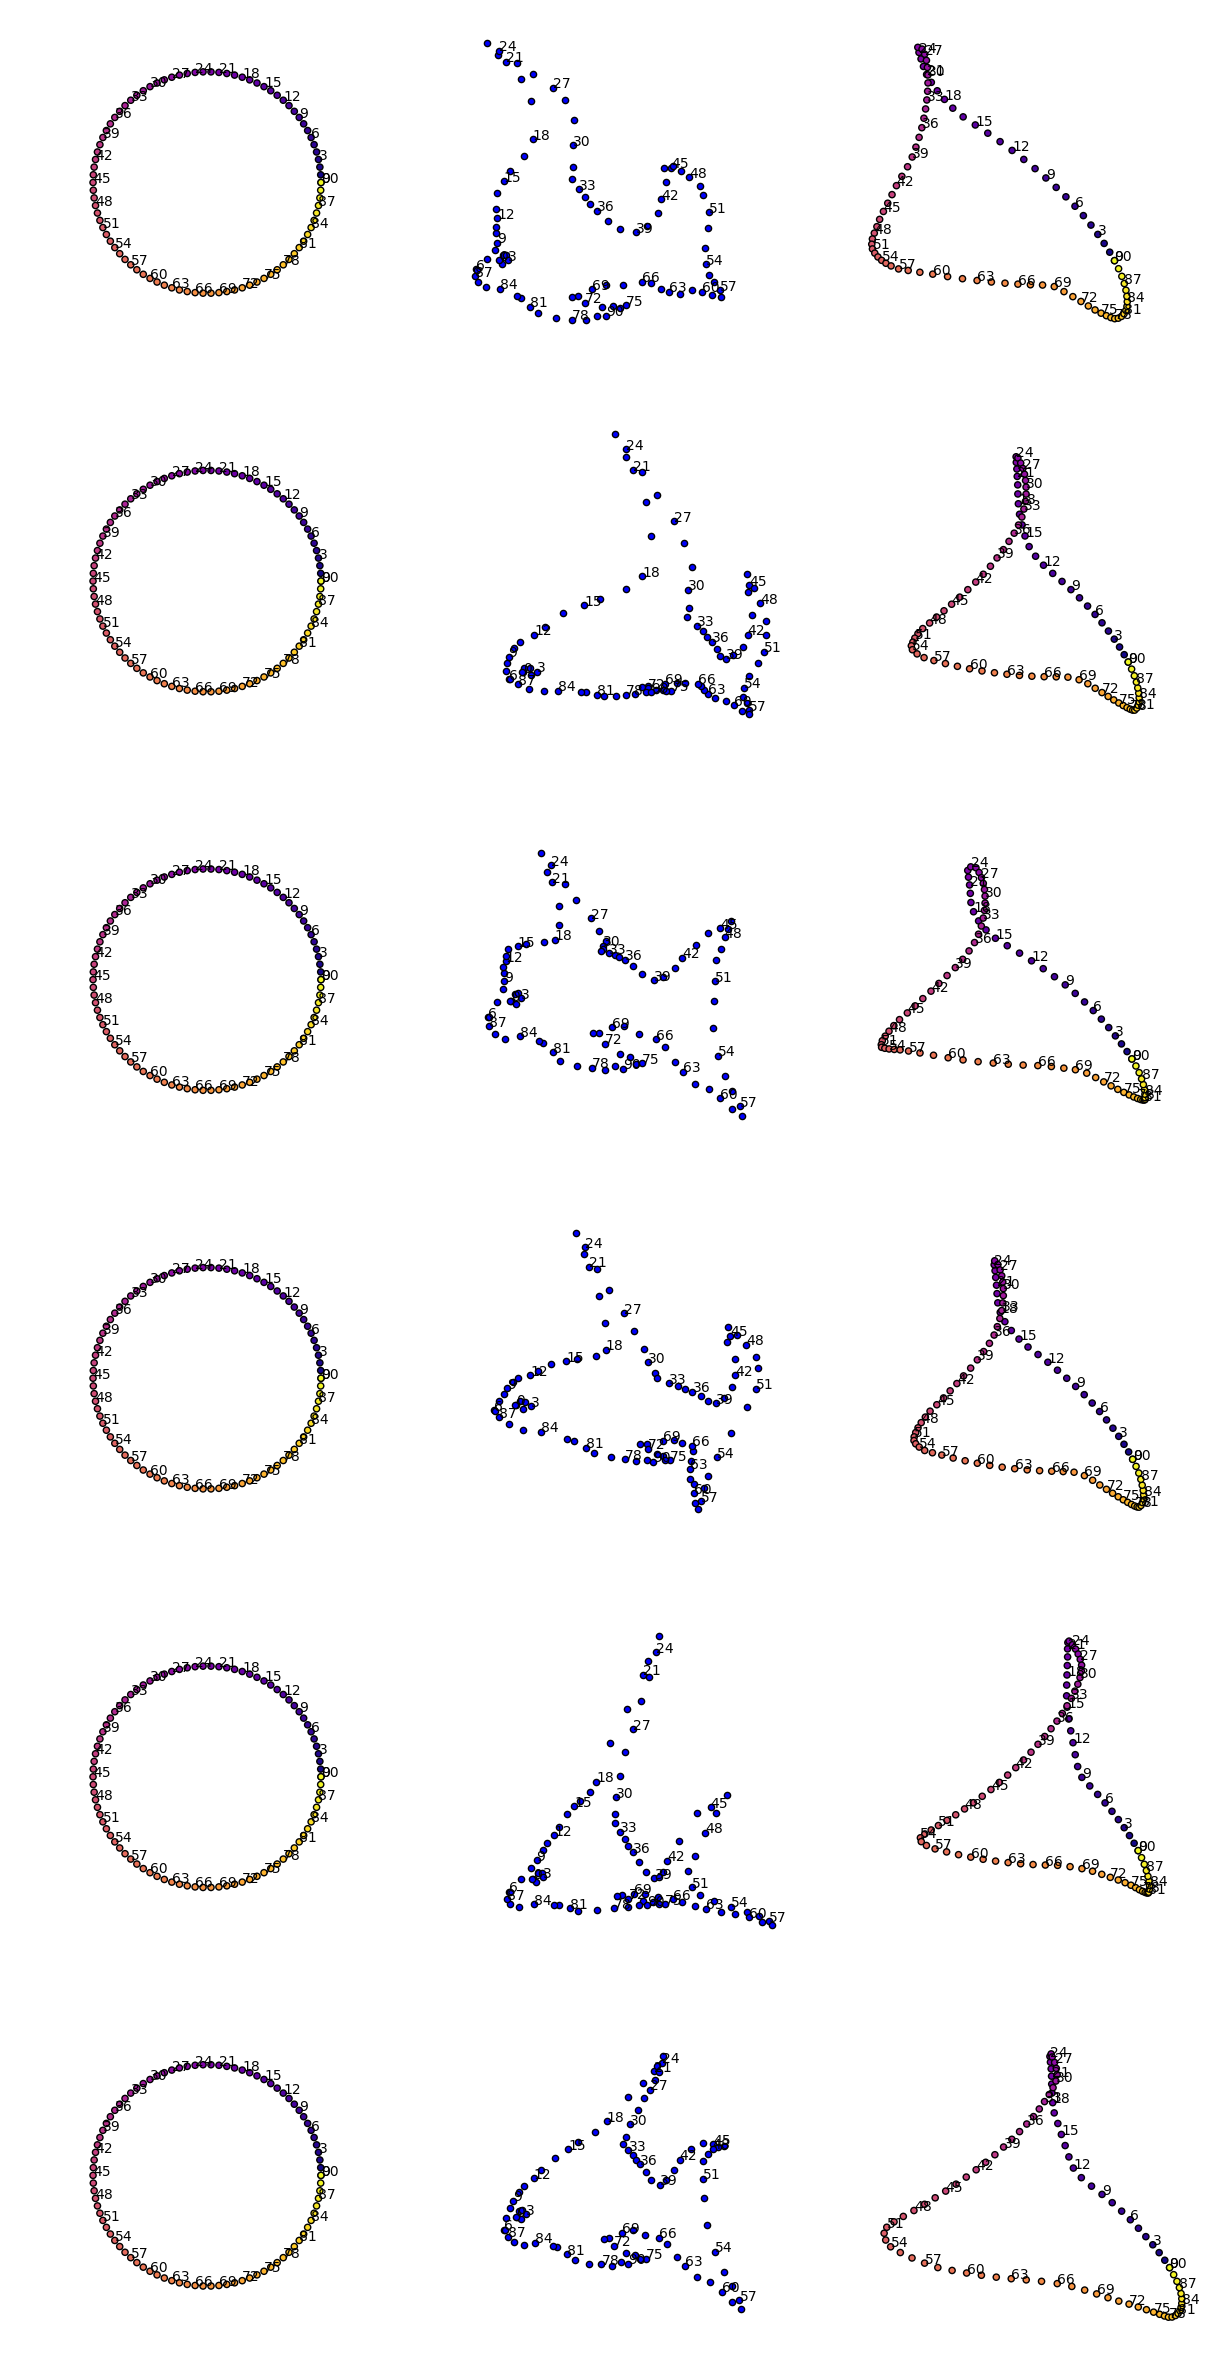

280.060072245


  0%|          | 395/600000 [00:25<10:46:07, 15.47it/s]

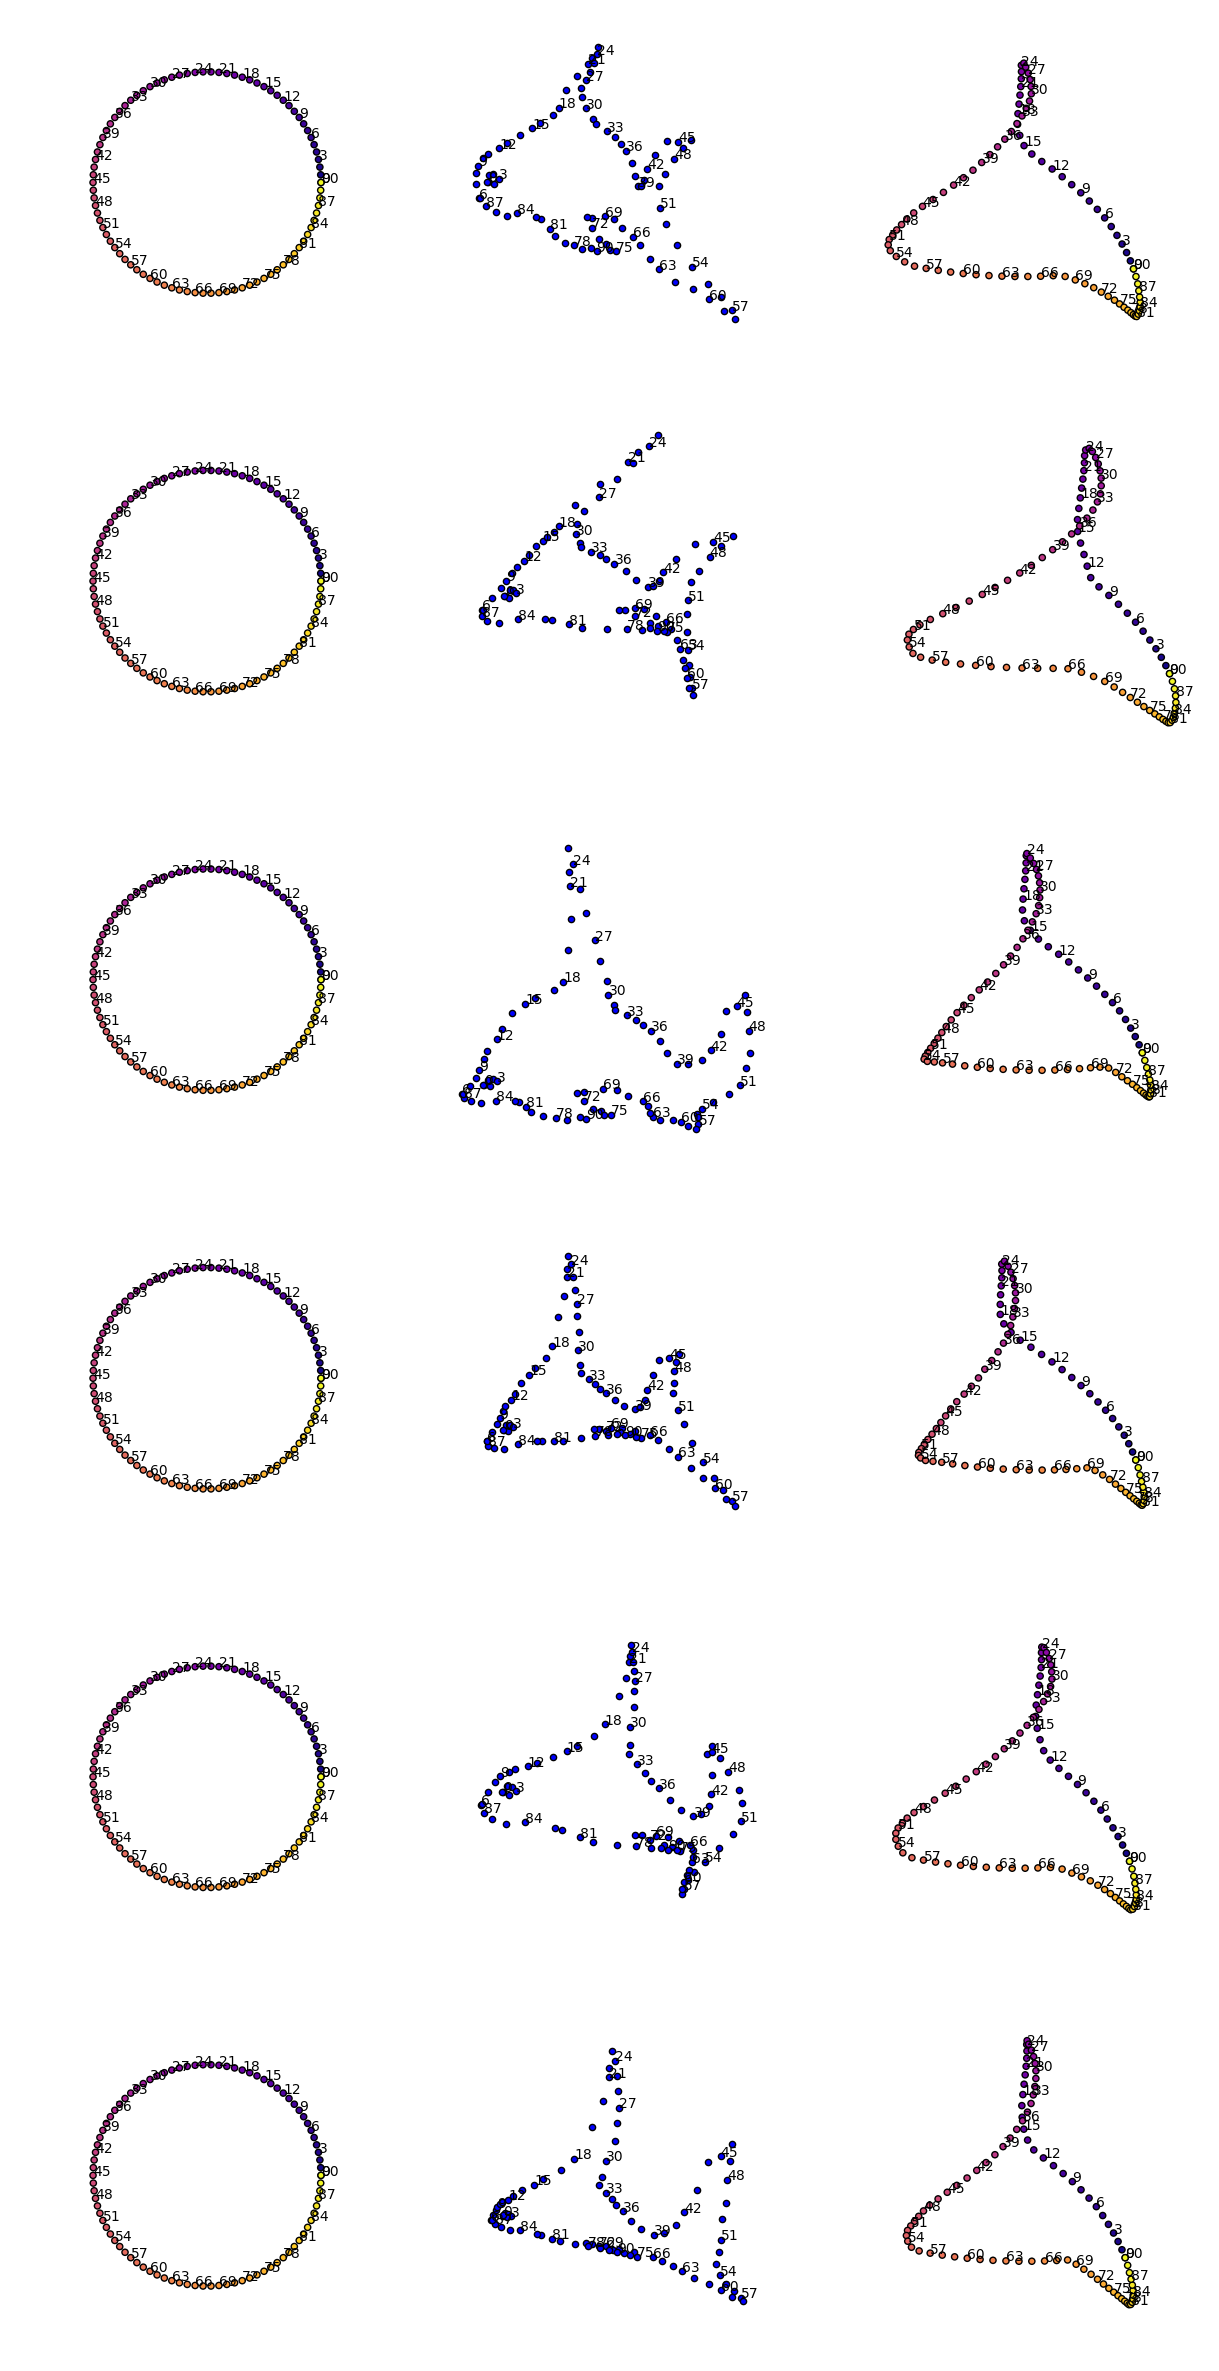

221.912236239


  0%|          | 493/600000 [00:33<11:09:16, 14.93it/s]

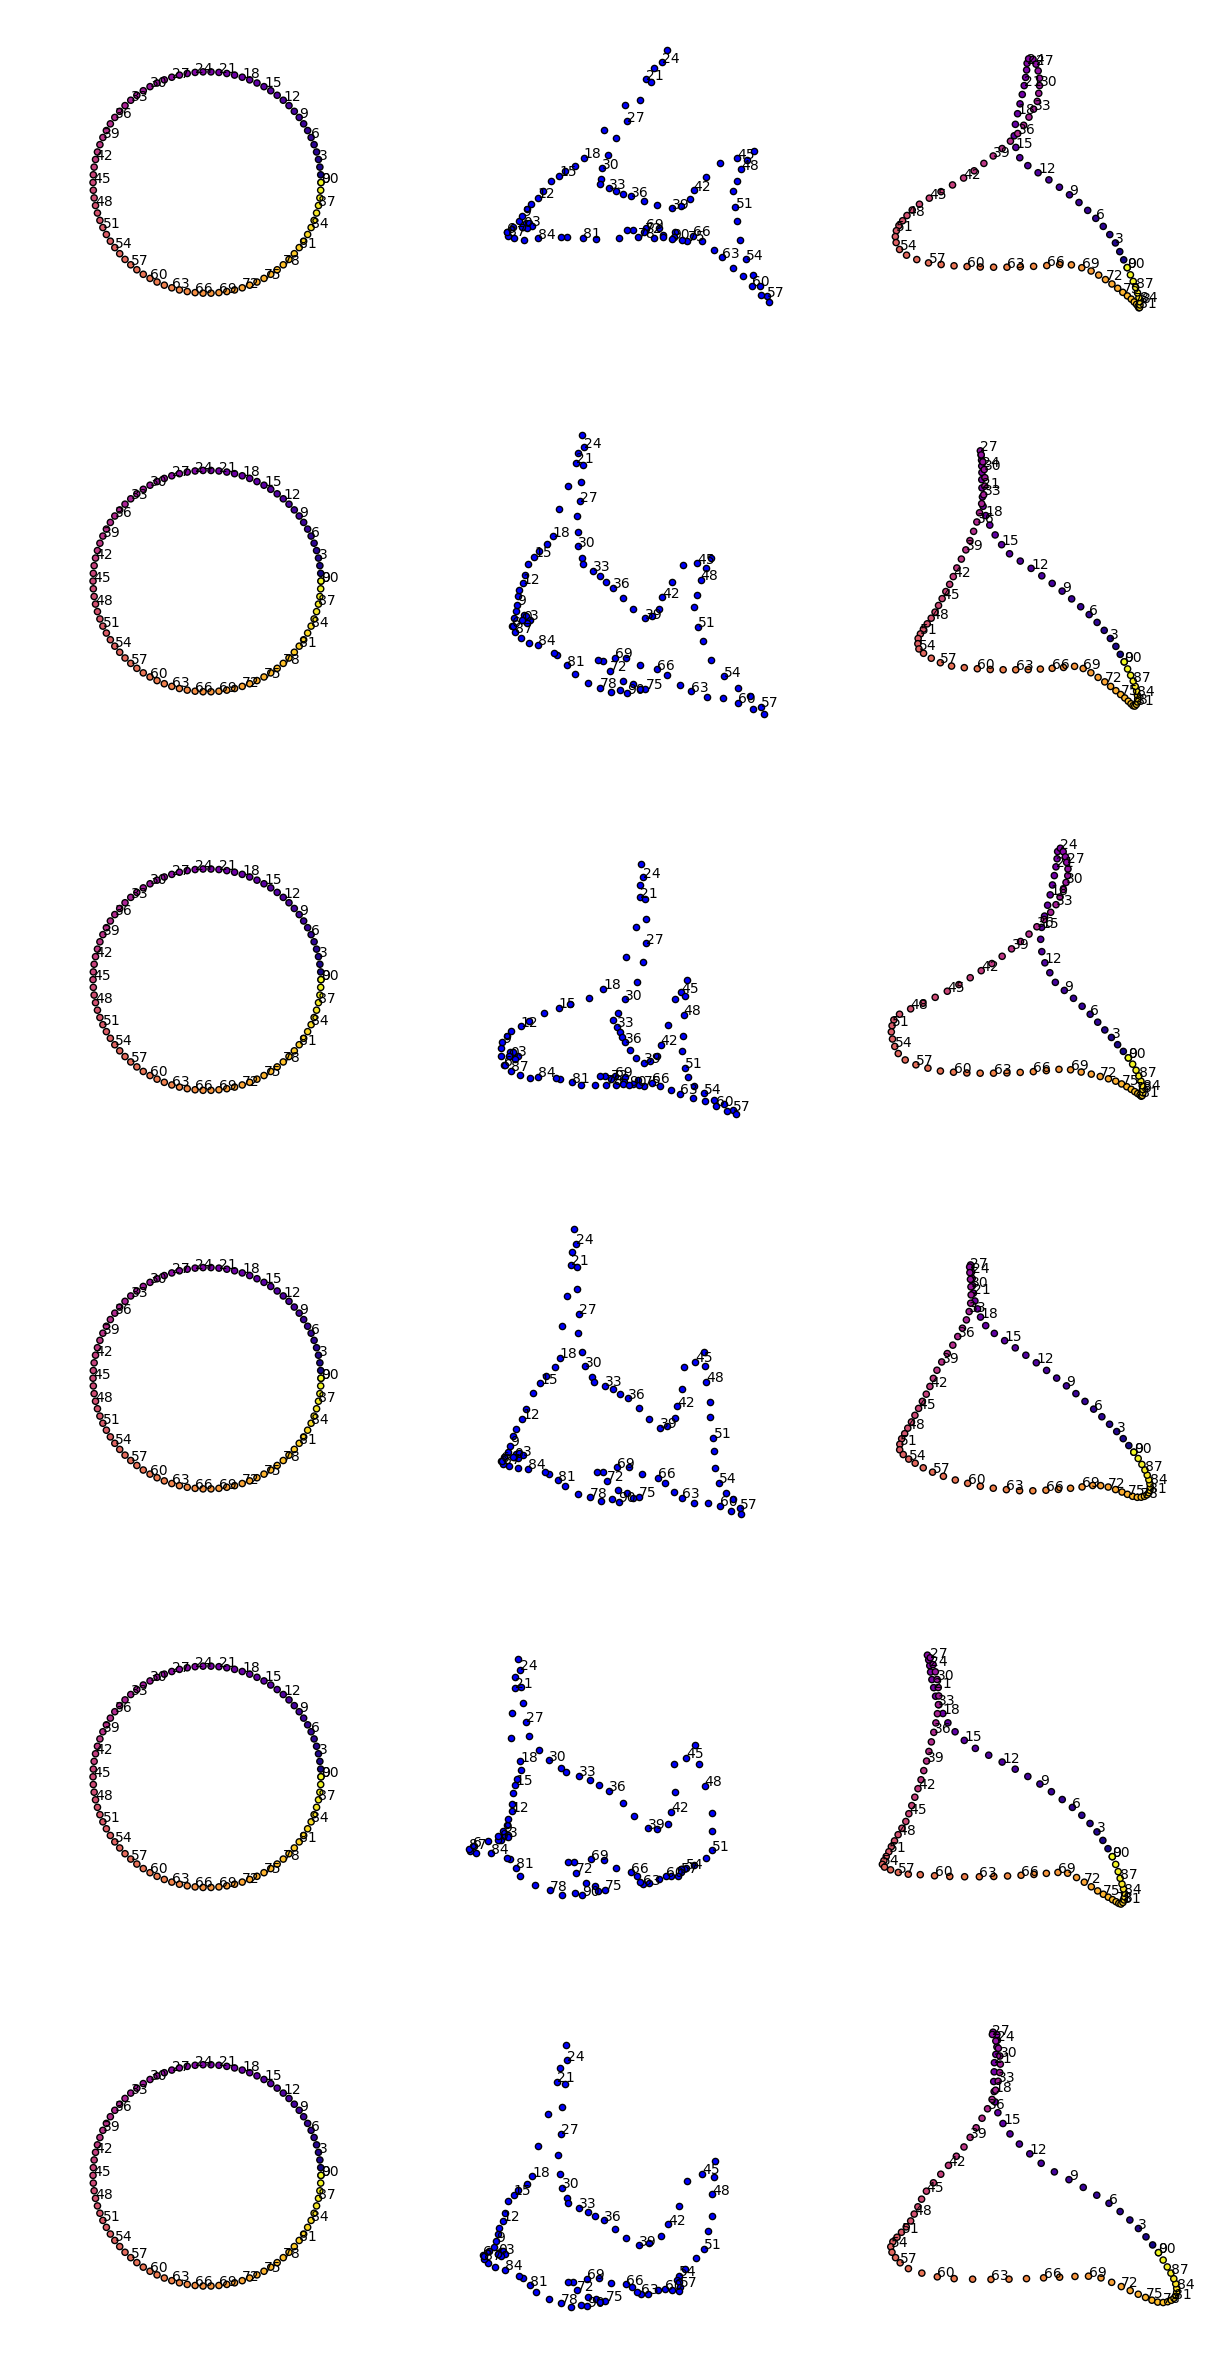

187.281732327


  0%|          | 995/600000 [00:49<8:12:06, 20.29it/s]

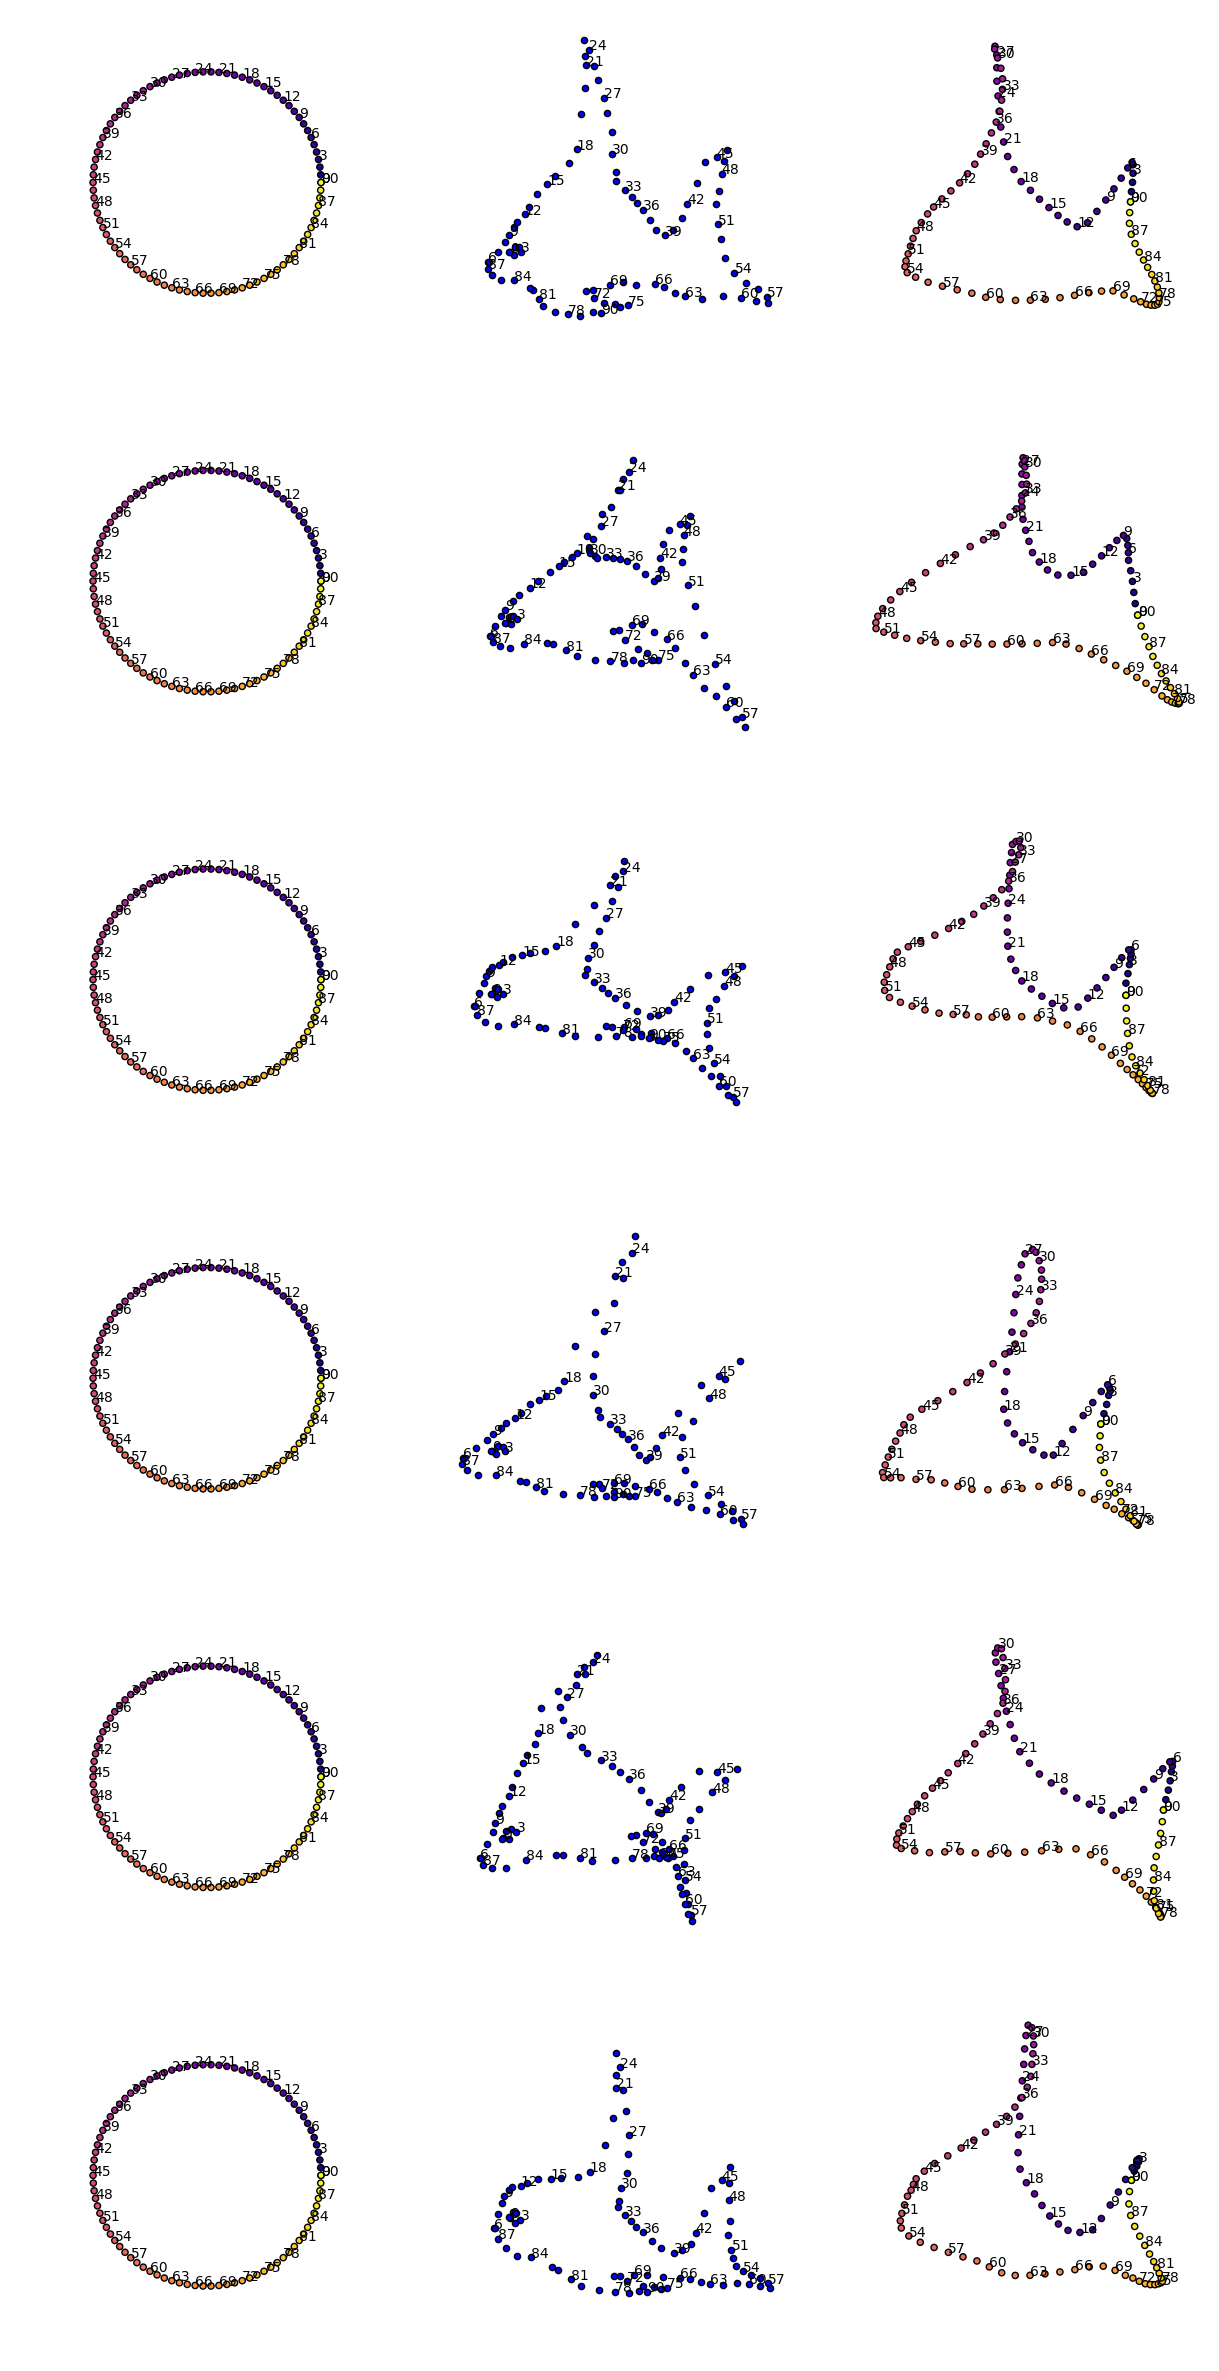

78.0492754102


  0%|          | 1495/600000 [01:05<7:18:46, 22.73it/s]

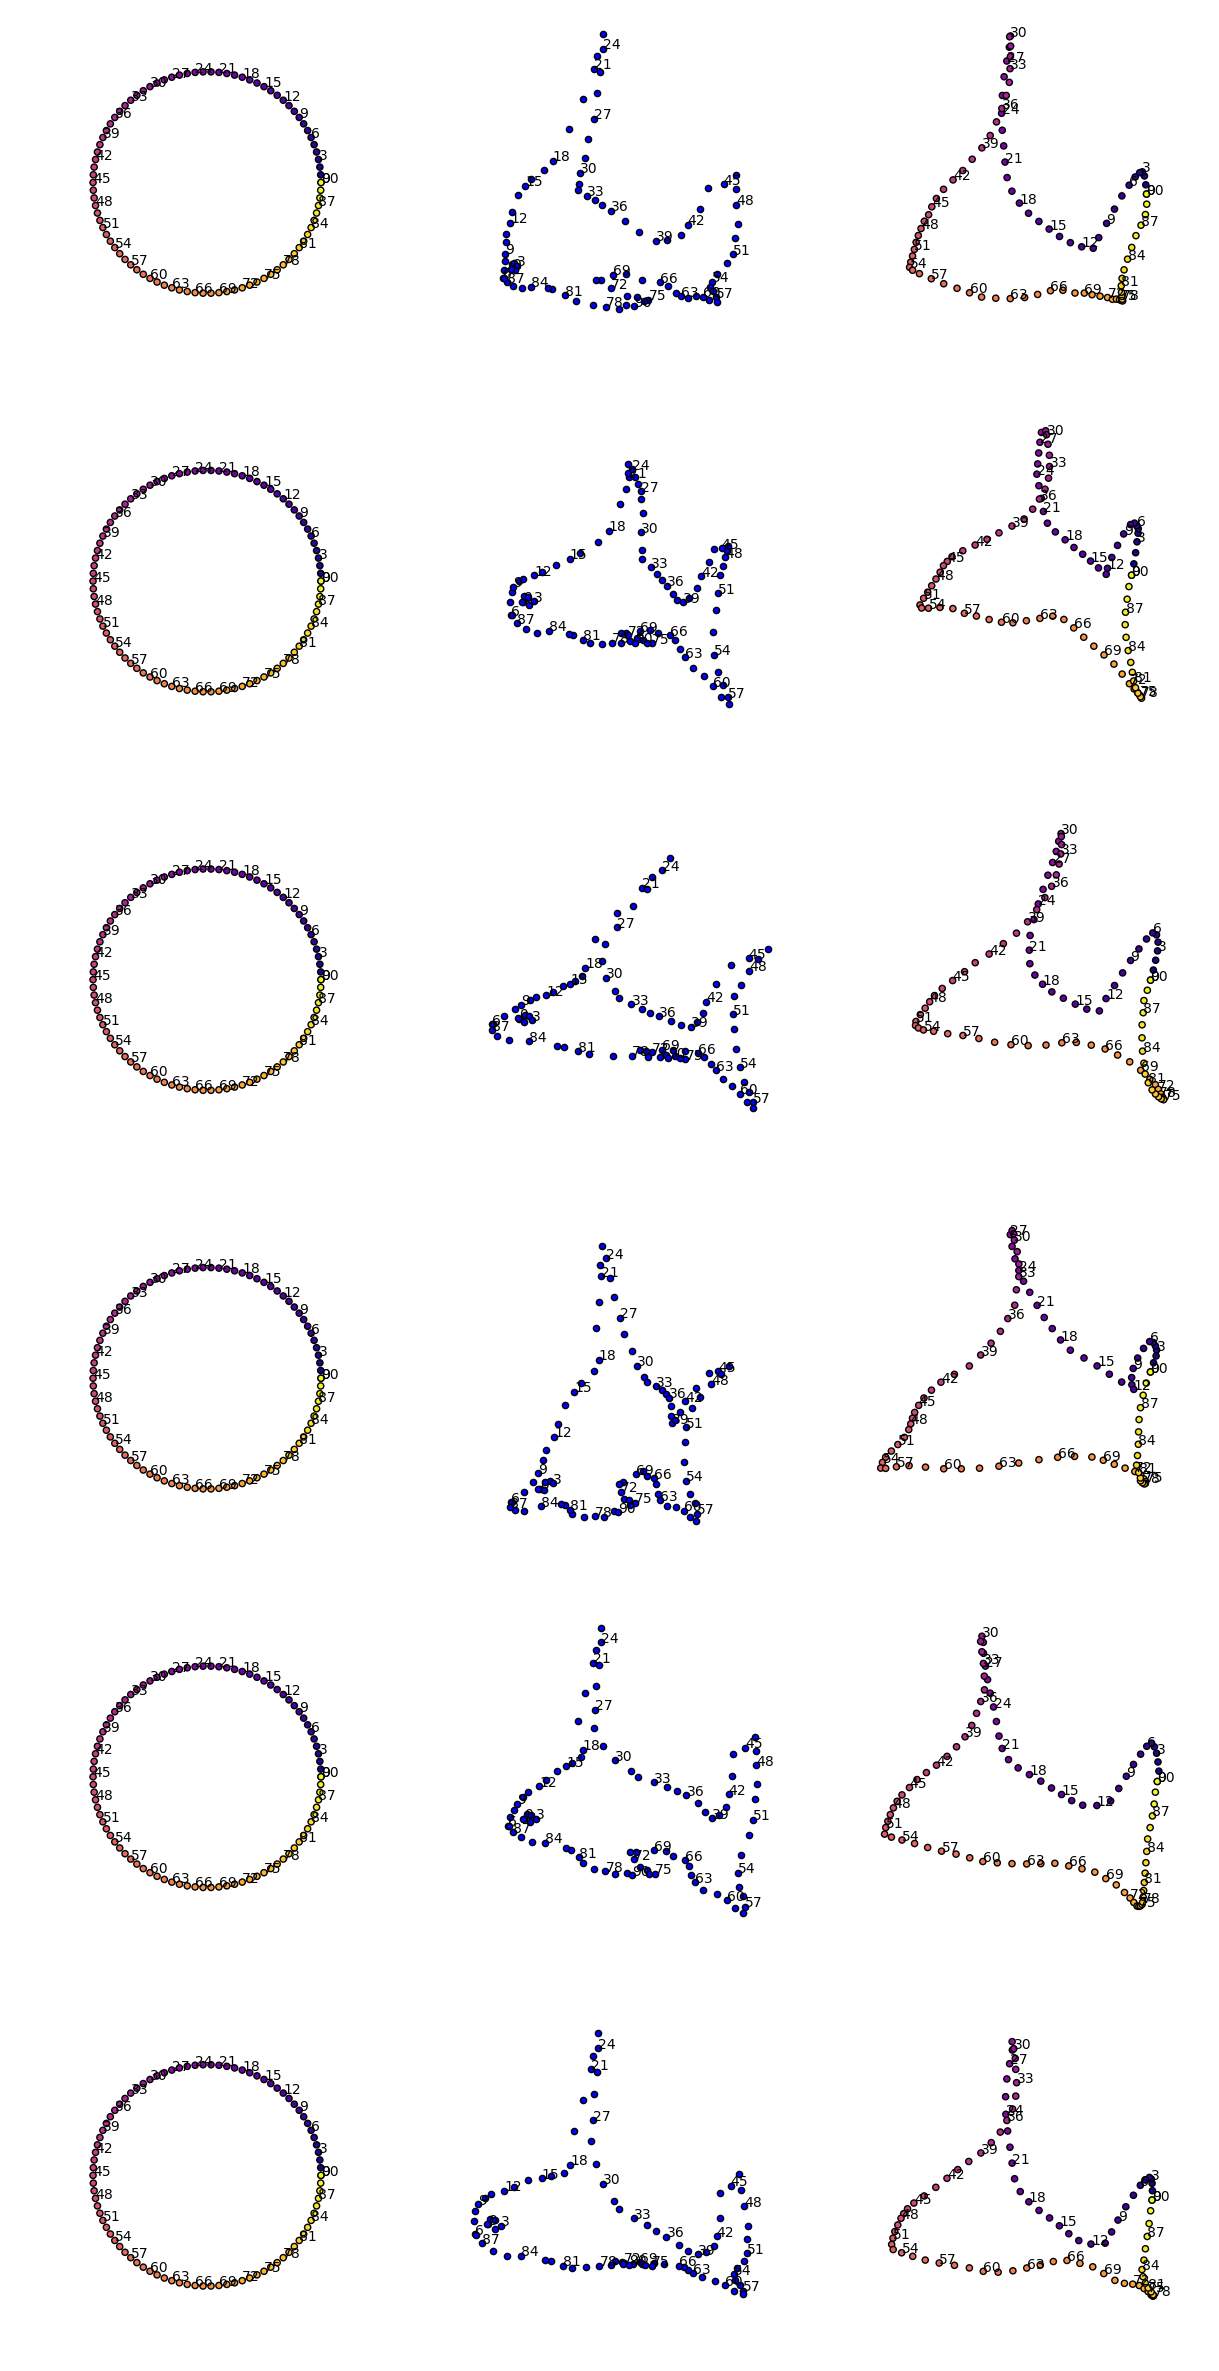

45.547335614


  0%|          | 1996/600000 [01:21<6:49:02, 24.37it/s]

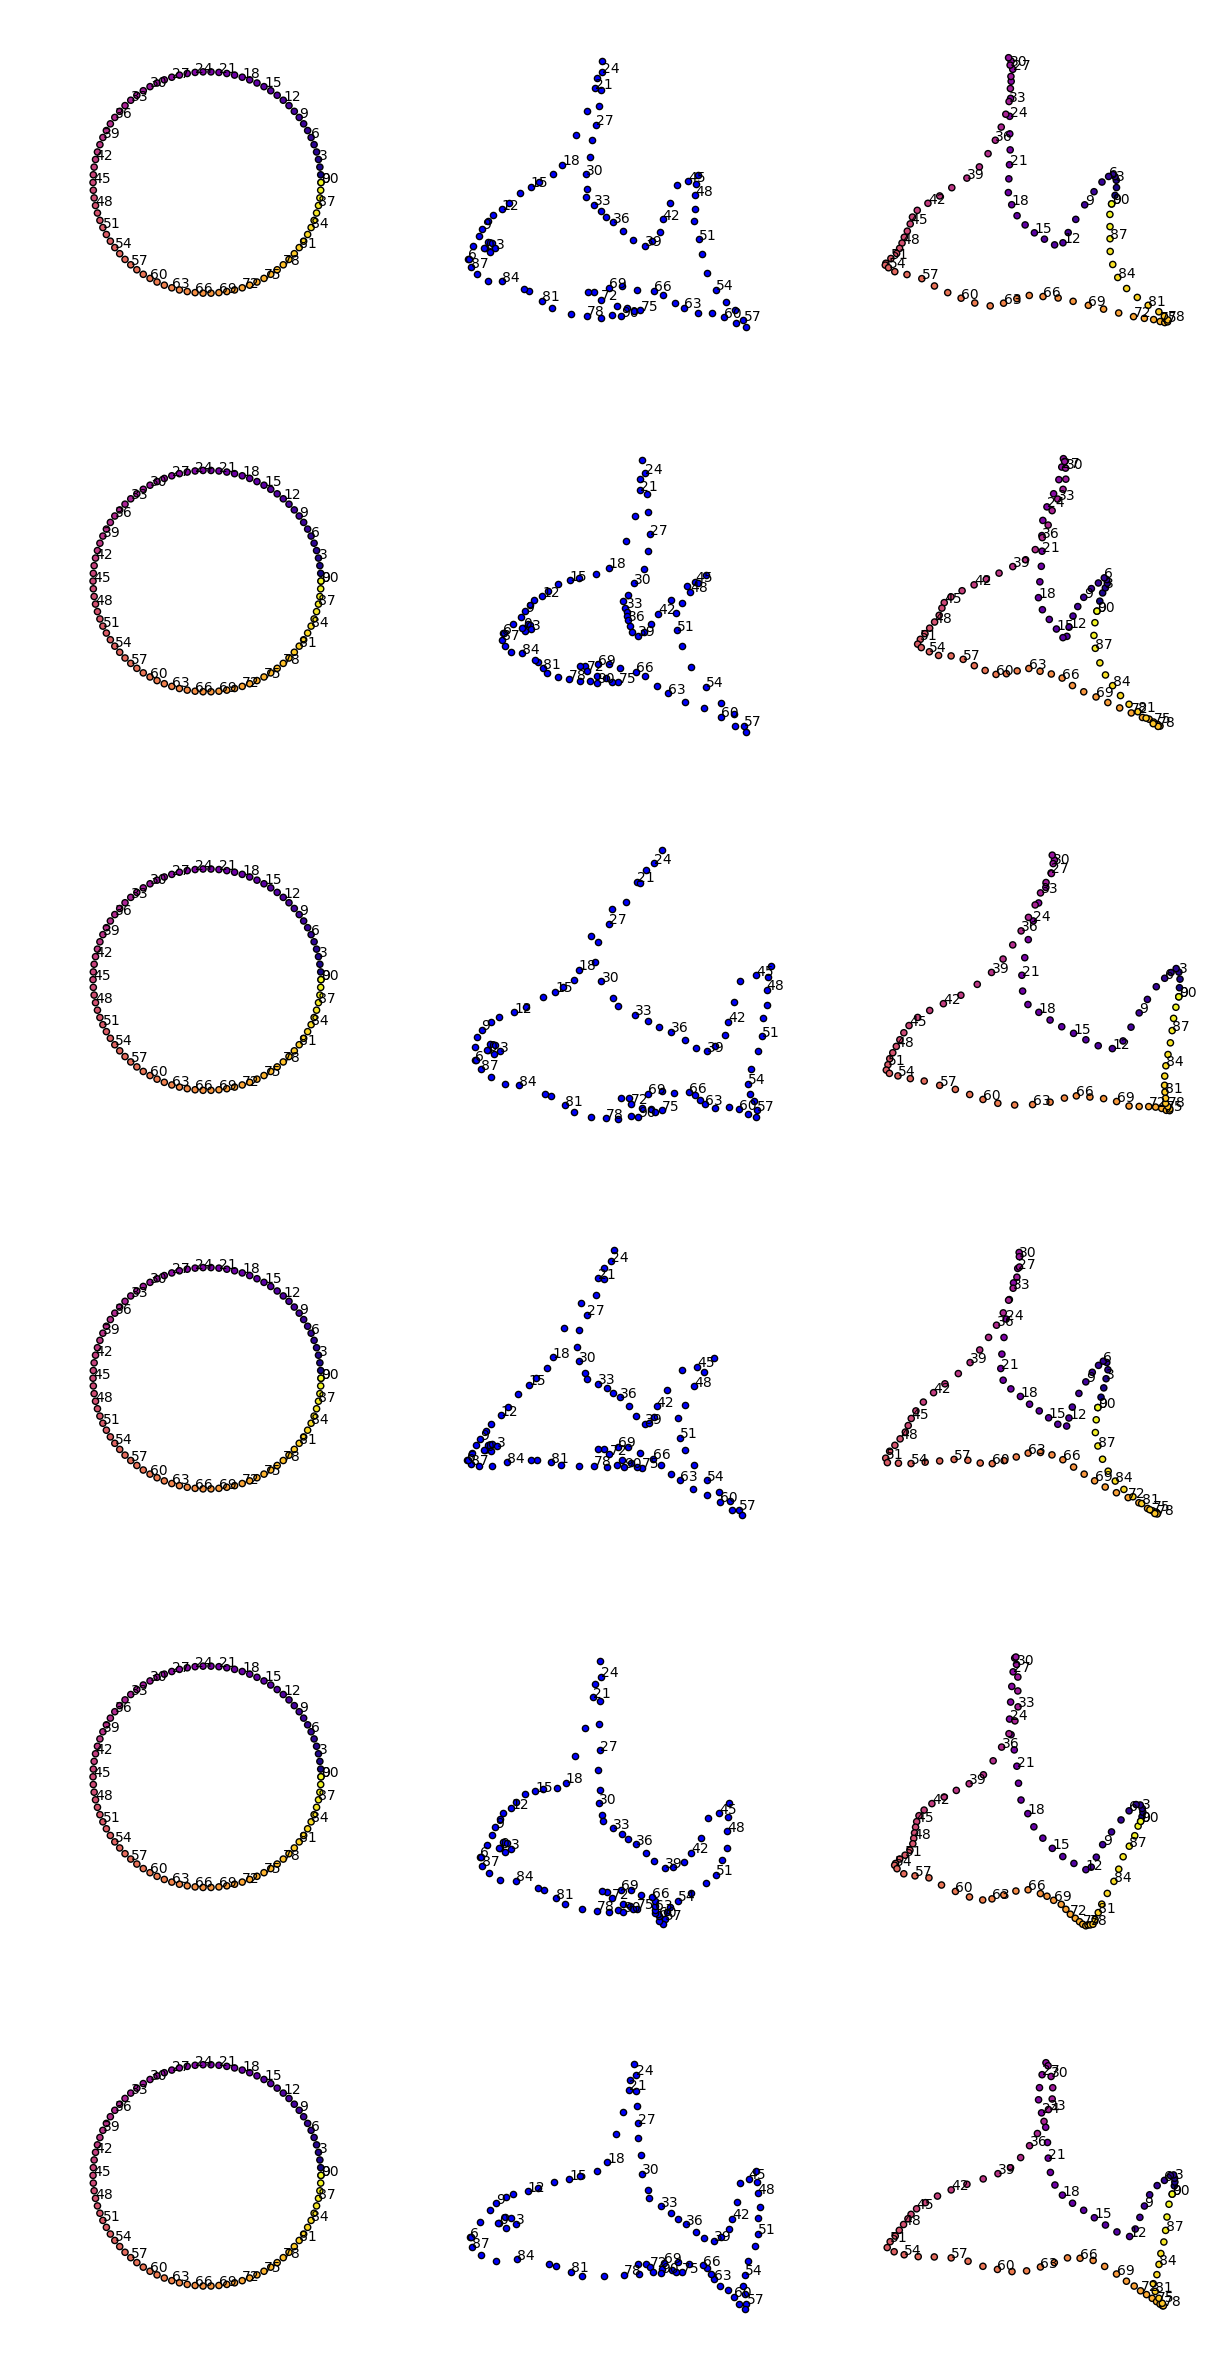

38.6444044784


  0%|          | 2259/600000 [01:32<6:50:03, 24.30it/s]

In [ ]:
train()